<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/likelihood_quadratic_appox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The packages

In [1]:
try:
  import iminuit
  from iminuit import Minuit
  import gammapy
  from gammapy.irf import Background3D

except:
  !pip install iminuit
  !pip install gammapy

     |████████████████████████████████| 317kB 5.7MB/s 
     |████████████████████████████████| 2.1MB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.2MB 23.4MB/s 
     |████████████████████████████████| 1.1MB 42.3MB/s 
     |████████████████████████████████| 645kB 46.7MB/s 
  Created wheel for gammapy: filename=gammapy-0.18.2-cp36-cp36m-linux_x86_64.whl size=726418 sha256=26750e787fe3edb8c6c9bc415831218205580db7ed04821f166a4e660b3e4e43
  Stored in directory: /root/.cache/pip/wheels/17/b3/1e/d3567858ee1a64459d0bec04f1f256c16dcfe750312bda0219
Successfully built gammapy
  Created wheel for regions: filename=regions-0.4-cp36-cp36m-linux_x86_64.whl size=963120 sha256=26eda13db4ac5fb52612f87cfbcee4730fcbcb40ae6da47b9c1efb3b66b5df89
  Stored in directory: /root/.cache/pip/wheels/64/40/0b/b4c2110e9d8fe132da7010597bb1e408bea60ef2a64b5a5058
Successfully built regions
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import astropy
from astropy.io import fits
import seaborn as sns
import time
import tqdm
from tqdm.auto import tqdm, trange
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection



In [ ]:
print (sns.__version__)

0.11.0


# The parameters


In [ ]:
roi = 5                       ## Our range of interest in degrees
TeV = 10**-6                  ## Convertion rate
energy_start_bin = 3
offset = 0                    ## The offset of the telescope. We assume we look at the target directly
pre_normalisation = 1
parsec = 3.08567758 * 10**18
Sun_to_centrum = 8122 * parsec
time_obs = 500 * 3600
pixel_size = (np.pi / 180)**2 * 0.5**2



For our analysis we can use two different Fermi Bubble models; $F_{min}$ and $F_{max}$. The option can be set here.



We are also including an option to mismodel te gas correlated emmision with different maps. This option can also be set here.


In [ ]:
Fermi_min = True
mismodelling = False
dark_matter_s = False                     

MC_times = 4                               ### The amount of monte carlo simulations.
ss_steps = 30                                ### The amount of signal steps we use.

all_injection_plots = True              ### If true it runs all the different types of injection spectra.
At_injection_spectra = 1                    ### The injection spectra we look at, only used when "all_injection_plots" is False.

# Data

In [ ]:
## The Energy is saved as a tuple, via this way we make it a normal list

ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   


## The raw data


### Cosmic Ray data


Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


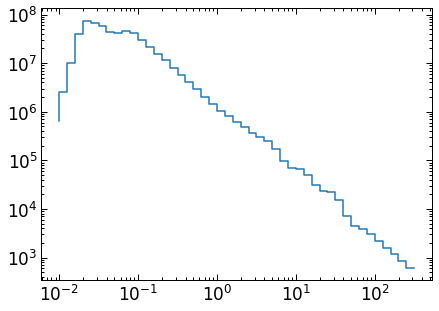

In [ ]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
irf_filename = pre_path + 'irf_file.fits'
bkg = Background3D.read(irf_filename, hdu='BACKGROUND')

def background(E):
  return bkg.evaluate(energy_reco = str(E)+ 'TeV', fov_lon = str(1) + 'deg',  fov_lat = str(1) + 'deg').to("TeV-1 s-1 sr-1")


background_counts = []

for i in range(len(energies)-1):
  tot_count = 0
  E1 = energies[i]
  E2 = energies[i+1]
  E = (E1*E2)**0.5
  dE = E2-E1
  counts = background(E) * dE 
  background_counts.append(counts)


total_bgcounts = np.array(background_counts) * time_obs * pixel_size * (4*roi*4*roi)

plt.step(energies[:-1],total_bgcounts)
plt.yscale('log')
plt.xscale('log')

res_back = []
for counts in total_bgcounts:
  res_back.append(np.full((4*roi,4*roi), counts / (4*roi*4*roi)))

res_back = np.array(res_back)



### Original model

In [ ]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

tot_ics = np.array(ics_ring_maps[0] + ics_ring_maps[1] + ics_ring_maps[2] + ics_ring_maps[3])
tot_gce = np.array(GCE_ring_maps[0] + GCE_ring_maps[1] + GCE_ring_maps[2] + GCE_ring_maps[3])


### GCE extrapolated from fermi

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/data_txt_files/"

df_ics = pd.read_table(path+ 'ICS_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

df_gce = pd.read_table(path+ 'GasCorrelated_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

Fermi_eneriges_ics = df_ics['Ecenter'] /1000
Fermi_flux_ics = df_ics['E^2dN/dE']/1000
error1 = df_ics['error']/1000

Fermi_eneriges_gce = df_gce['Ecenter']/1000
Fermi_flux_gce = df_gce['E^2dN/dE']/1000
error2 = df_gce['error']/1000

def func(E, *param):
  return (param[0] * E**-param[1])

param,errors = scipy.optimize.curve_fit(func,Fermi_eneriges_gce, Fermi_flux_gce,p0 = [[10**-8,2]])
fit_func1 = [func(E,*param) for E in Fermi_eneriges_gce]
fit_func2 = [func(E,*param) for E in energies]

energy_bin = 10
GCE_ring_1_temp = GCE_ring_maps[0][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_2_temp = GCE_ring_maps[1][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_3_temp = GCE_ring_maps[2][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_4_temp = GCE_ring_maps[3][energy_bin] / np.mean(tot_gce[energy_bin]) 

new_GCE_1 = []
new_GCE_2 = []
new_GCE_3 = []
new_GCE_4 = []

param2 = [param[0], param[1] +2]
for E in energies:
  new_GCE_1.append(GCE_ring_1_temp * func(E, *param2))
  new_GCE_2.append(GCE_ring_2_temp * func(E, *param2))
  new_GCE_3.append(GCE_ring_3_temp * func(E, *param2))
  new_GCE_4.append(GCE_ring_4_temp * func(E, *param2))

new_GCE_1 = np.array(new_GCE_1)
new_GCE_2 = np.array(new_GCE_2)
new_GCE_3 = np.array(new_GCE_3)
new_GCE_4 = np.array(new_GCE_4)

tot_new_GCE = new_GCE_1 + new_GCE_2 + new_GCE_3 + new_GCE_4 

### The fermi maps

In [ ]:
fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')[(40 - 2*roi):(40 + 2 * roi),(40 - 2*roi):(40 + 2 * roi)]
fermi_map = fermi_map / np.mean(fermi_map)

def fermi_function_min(E):
  phi0 = 0.5 * 10**-8
  sigma = 1.9
  E_co = 1

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq

def fermi_function_max(E):
  phi0 = 1 * 10**-8
  sigma = 1.9
  E_co = 20

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq


fermi_binned_min = []
fermi_binned_max = []

for E in energies:
  fermi_binned_min.append(fermi_map * fermi_function_min(E))
  fermi_binned_max.append(fermi_map * fermi_function_max(E))


fermi_binned_min = np.array(fermi_binned_min)
fermi_binned_max = np.array(fermi_binned_max)



In [ ]:
print (energies)

[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02]


$dN/dE=N_0\; (E/{\rm 1\; TeV})^{-\Gamma}\exp(-E/{E_{cut}})$



### Alternative model

In [ ]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)



H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)


initial_norm_factor = (np.sum(H1_maps) + np.sum(H2_maps) + np.sum(dust_neg + dust_pos) ) / np.sum(GCE_ring_maps) 


H1_norm = []
H2_norm = []
dust_pos_norm = dust_pos / initial_norm_factor
dust_neg_norm = dust_neg / initial_norm_factor

for i in range(0,4):
  H1_norm.append(H1_maps[i] / initial_norm_factor )
  H2_norm.append(H1_maps[i] / initial_norm_factor )
import scipy

tot_alter = np.sum(H1_maps) + np.sum(H1_maps) + np.sum(dust_pos)+ np.sum(dust_neg) 
sum_gce = np.sum(tot_gce)

l2 = []
for i in range(47):
  l2.append(np.sum(tot_gce[i]))

def func(E,a,b,c):
  return (a * (E/b)**-c)

p1,p2 = scipy.optimize.curve_fit(func,energies, l2)


norm_factor = sum_gce / tot_alter

def func(E):
  b = float(0.2)
  c = float(2.5)

  return ((E/b)**-c * norm_factor *10**-3.8)



H1_1_binned = []
H1_2_binned = []
H1_3_binned = []
H1_4_binned = []

H2_1_binned = []
H2_2_binned = []
H2_3_binned = []
H2_4_binned = []

dust_binned_pos = []
dust_binned_neg = []

for E in energies:
  H1_1_binned.append(H1_maps[0] * func(E))
  H1_2_binned.append(H1_maps[1] * func(E))
  H1_3_binned.append(H1_maps[2] * func(E))
  H1_4_binned.append(H1_maps[3] * func(E))

  H2_1_binned.append(H2_maps[0] * func(E))
  H2_2_binned.append(H2_maps[1] * func(E))
  H2_3_binned.append(H2_maps[2] * func(E))
  H2_4_binned.append(H2_maps[3] * func(E))

  dust_binned_pos.append(dust_pos * func(E))
  dust_binned_neg.append(dust_neg * func(E))

tot_alt = [H1_1_binned,H1_2_binned, H1_3_binned, H1_4_binned, H2_1_binned,H2_2_binned, H2_3_binned, H2_4_binned,dust_binned_pos,dust_binned_neg]
tot_alt = np.array(tot_alt)

tot_gce_alt = np.sum(tot_alt, axis = 0)


H1_1_binned = np.array(H1_1_binned)
H1_2_binned = np.array(H1_2_binned)
H1_3_binned = np.array(H1_3_binned)
H1_4_binned = np.array(H1_4_binned)

H2_1_binned = np.array(H2_1_binned)
H2_2_binned = np.array(H2_2_binned)
H2_3_binned = np.array(H2_3_binned)
H2_4_binned = np.array(H2_4_binned)

dust_binned_pos = np.array(dust_binned_pos)
dust_binned_neg = np.array(dust_binned_neg)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power


### Signal maps

In [ ]:
path_to_signal = '/content/drive/My Drive/Colab Notebooks/data_txt_files/NB_and_F98/'

NB_ring_maps = []
F98_ring_maps = []

for i in range(0,5):
  NB_map = np.roll(fits.getdata(path_to_signal + 'ics_anisotropic_mapcube_56_F98bar_inj' + str(i) +'.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  F98_map = np.roll(fits.getdata(path_to_signal + 'ics_anisotropic_mapcube_56_NB_inj' + str(i) +'.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  NB_ring_maps.append(NB_map)
  F98_ring_maps.append(F98_map)


NB_ring_maps = np.array(NB_ring_maps)
F98_ring_maps = np.array(F98_ring_maps)

signals = NB_ring_maps + F98_ring_maps


In [ ]:
dark_matter = np.roll(fits.getdata(path_to_signal + 'ics_anisotropic_mapcube_56_NFW_inj0.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]

dark_matter = np.array(dark_matter)


We have the following Background flux maps

* 4 rings of ics maps 47 * 20 * 20
* 4 rings of GCE maps 47 * 20 * 20
* 1 Fermi min map 47 * 20 * 20
* 1 Fermi max map 47 * 20 * 20

An alternative GCE map extrapolated from Fermi dataL

* 4 rings of GCE maps 47 * 20 * 20


And for the alternative model:

* 4 ring maps H1 40 * 40
* 4 ring maps H2 40 * 40
* 2 dust maps 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 47 * 20 * 20
* 5  injection spectra F98 map 47 * 20 * 20

## Convolved data

In [ ]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'

orig_shape = (9, 47, 20, 20)
original_file = files_paths + 'Model_new.txt.txt'
simulated_backgrounds = np.loadtxt(original_file).reshape(orig_shape)

ics_rings = np.loadtxt(files_paths + 'ice_file.txt').reshape(4,46,20,20)
gce_rings = np.loadtxt(files_paths + 'gce_file.txt').reshape(4,46,20,20)
gce2_rings = np.loadtxt(files_paths + 'gce2_file.txt').reshape(4,46,20,20)
NB_rings = np.loadtxt(files_paths + 'NB_file.txt').reshape(5,46,20,20)
F98_rings = np.loadtxt(files_paths + 'F98_file.txt').reshape(5,46,20,20)
signal_rings = np.loadtxt(files_paths + 'signal_file.txt').reshape(5,46,20,20)
alternative_gce = np.loadtxt(files_paths + 'Alternative_gce.txt').reshape(10,46,20,20)
fermi_maps = np.loadtxt(files_paths + 'fermi_map').reshape(2,46,20,20)
fermi_bubble = simulated_backgrounds[-1][:-1] * 137
dark_matter_map = np.loadtxt(files_paths + 'dark_matter_map').reshape(46,20,20)


signal_inj_list = signal_rings
all_backgrounds = np.array([ics_rings[0], ics_rings[1], ics_rings[2], ics_rings[3], gce_rings[0], gce_rings[1], gce_rings[2], gce_rings[3],fermi_bubble])


We have the following Background Count maps

* 4 rings of ics maps 46 * 20 * 20
* 4 rings of GCE maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20


And for the alternative model:


* 4 ring maps H1 46 * 40 * 40
* 4 ring maps H2 46 * 40 * 40
* 4 rings of ics 46 * 20 * 20
* 2 dust maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 46 * 20 * 20
* 5  injection spectra F98 map 46 * 20 * 20

###Alternative mask matrix

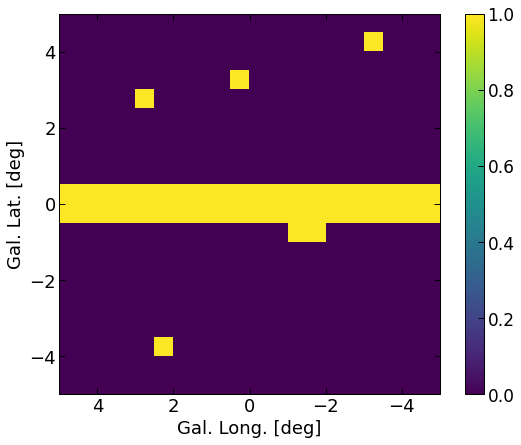

In [ ]:
def mask_matrix_fu():

  catalog = fits.open(pre_path + 'gll_psch_v13.fit')

  ptsrc_long = []
  ptsrc_lat = []

  # Here is load all the point sources in our range of interest:
  for i in range(len(catalog[1].data)):
      if(catalog[1].data[i][9] > 4.0 and catalog[1].data[i][33] == ''):
          if(-roi + 180 <= catalog[1].data[i][3] <= roi + 180):
              if(-roi <= catalog[1].data[i][4] <= roi):
                  ptsrc_long.append(catalog[1].data[i][3])
                  ptsrc_lat.append(catalog[1].data[i][4])

  # Here I make a matrix that has a zero on all the positions that are +/- 0.25 degrees away from
  # a Fermi high energy source. Also the galactic ridge (+/- 0.3 degrees lattitude) are maskt.
  mask_matrix = []
  y_coor = 0
  x_min = 180 - roi
  x_max = 180 + roi
  y_min = - roi
  y_max = roi
  y_steps = 4 * roi
  x_steps = 4 * roi

  for y in np.linspace(y_max, y_min, y_steps):
      mask_matrix.append([])
      for x in np.linspace(x_min, x_max, x_steps):
          mark = 0
          for i in range(len(ptsrc_long)):
              ps_x = ptsrc_long[i]
              ps_y = ptsrc_lat[i]
              if abs(ps_x - x) < 0.25:
                  if abs(ps_y - y) < 0.25:
                      mark = 1
                      break
  #            if ((ps_x - x)**2 + (ps_y - y)**2)**0.5  < 0.25:
  #                mark = 0
          if abs(y) < 0.3:
              mark = 1
          mask_matrix[y_coor].append(mark)
      y_coor += 1

  mask_matrix = np.array(mask_matrix)
  return mask_matrix

mask_matrix = mask_matrix_fu()

x = np.arange(-roi,roi,0.5)
y = np.arange(-roi,roi,0.5)
xx, yy = np.meshgrid(x, y, sparse=True)
#dist = np.sqrt(xx**2 + yy**2)
dist = np.sqrt((xx-1.29)**2 + (yy-0.64)**2) #for a disk at (x,y)=(0.5,0.5)
mask_matrix[dist<0.4] = 1.





mask2 = []

for i in range(11):
  mask2.append(mask_matrix)

mask2 = np.array(mask2)

plt.figure(figsize=(9,7))
plt.xlabel("Gal. Long. [deg]",fontsize=18)
plt.ylabel("Gal. Lat. [deg]",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.imshow(mask2[0], extent = [roi,-roi,-roi,roi])
plt.colorbar()
plt.show()


## Compressing again to 11 rings

In [ ]:
res_back_template = []

Ics_ring_1_template = []
Ics_ring_2_template = []
Ics_ring_3_template = []
Ics_ring_4_template = []
GCE_ring_1_template = []
GCE_ring_2_template = []
GCE_ring_3_template = []
GCE_ring_4_template = []

fermi_template = []

signal_0_template = []
signal_1_template = []
signal_2_template = []
signal_3_template = []
signal_4_template = []


H1_ring_1_template = []
H1_ring_2_template = []
H1_ring_3_template = []
H1_ring_4_template = []

H2_ring_1_template = []
H2_ring_2_template = []
H2_ring_3_template = []
H2_ring_4_template = []

dust_pos_template = []
dust_neg_template = []

dark_matter_template = []

new_energies = []

for j in range(0,11):
  i = 2+j*4
  new_energies.append(energies[i])

  res_back_template.append(np.sum(res_back[i:i+4], axis = 0))

  Ics_ring_1_template.append(np.sum(ics_rings[0][i:i+4], axis = 0))
  Ics_ring_2_template.append(np.sum(ics_rings[1][i:i+4], axis = 0))
  Ics_ring_3_template.append(np.sum(ics_rings[2][i:i+4], axis = 0))
  Ics_ring_4_template.append(np.sum(ics_rings[3][i:i+4], axis = 0))

  GCE_ring_1_template.append(np.sum(gce_rings[0][i:i+4], axis = 0))
  GCE_ring_2_template.append(np.sum(gce_rings[1][i:i+4], axis = 0))
  GCE_ring_3_template.append(np.sum(gce_rings[2][i:i+4], axis = 0))
  GCE_ring_4_template.append(np.sum(gce_rings[3][i:i+4], axis = 0))

  if Fermi_min:
    fermi_template.append(np.sum(fermi_maps[0][i:i+4], axis = 0))
  else:
    fermi_template.append(np.sum(fermi_maps[1][i:i+4], axis = 0))

  signal_0_template.append(np.sum(signal_rings[0][i:i+4], axis = 0))
  signal_1_template.append(np.sum(signal_rings[1][i:i+4], axis = 0))
  signal_2_template.append(np.sum(signal_rings[2][i:i+4], axis = 0))
  signal_3_template.append(np.sum(signal_rings[3][i:i+4], axis = 0))
  signal_4_template.append(np.sum(signal_rings[4][i:i+4], axis = 0))

  dark_matter_template.append(np.sum(dark_matter_map[i:i+4], axis = 0))


  H1_ring_1_template.append(np.sum(alternative_gce[0][i:i+4], axis = 0))
  H1_ring_2_template.append(np.sum(alternative_gce[1][i:i+4], axis = 0))
  H1_ring_3_template.append(np.sum(alternative_gce[2][i:i+4], axis = 0))
  H1_ring_4_template.append(np.sum(alternative_gce[3][i:i+4], axis = 0))

  H2_ring_1_template.append(np.sum(alternative_gce[4][i:i+4], axis = 0))
  H2_ring_2_template.append(np.sum(alternative_gce[5][i:i+4], axis = 0))
  H2_ring_3_template.append(np.sum(alternative_gce[6][i:i+4], axis = 0))
  H2_ring_4_template.append(np.sum(alternative_gce[7][i:i+4], axis = 0))

  dust_pos_template.append(np.sum(alternative_gce[8][i:i+4], axis = 0))
  dust_neg_template.append(np.sum(alternative_gce[9][i:i+4], axis = 0))



res_back_template = np.array(res_back_template )

Ics_ring_1_template = np.array(Ics_ring_1_template)
Ics_ring_2_template = np.array(Ics_ring_2_template)
Ics_ring_3_template = np.array(Ics_ring_3_template)
Ics_ring_4_template = np.array(Ics_ring_4_template)
GCE_ring_1_template = np.array(GCE_ring_1_template)
GCE_ring_2_template = np.array(GCE_ring_2_template)
GCE_ring_3_template = np.array(GCE_ring_3_template)
GCE_ring_4_template = np.array(GCE_ring_4_template)

fermi_template = np.array(fermi_template)

signal_0_template = np.array(signal_0_template)
signal_1_template = np.array(signal_1_template)
signal_2_template = np.array(signal_2_template)
signal_3_template = np.array(signal_3_template)
signal_4_template = np.array(signal_4_template)

signal_templates = np.array([signal_0_template, signal_1_template, signal_2_template, signal_3_template, signal_4_template])


H1_ring_1_template = np.array(H1_ring_1_template)
H1_ring_2_template = np.array(H1_ring_2_template)
H1_ring_3_template = np.array(H1_ring_3_template)
H1_ring_4_template = np.array(H1_ring_4_template)

H2_ring_1_template = np.array(H2_ring_1_template)
H2_ring_2_template = np.array(H2_ring_2_template)
H2_ring_3_template = np.array(H2_ring_3_template)
H2_ring_4_template = np.array(H2_ring_4_template)

dust_pos_template = np.array(dust_pos_template)
dust_neg_template = np.array(dust_neg_template)

dark_matter_template = np.array(dark_matter_template)

# Creating the synthetic data

### the sythentic data

(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)
(11, 20, 20)


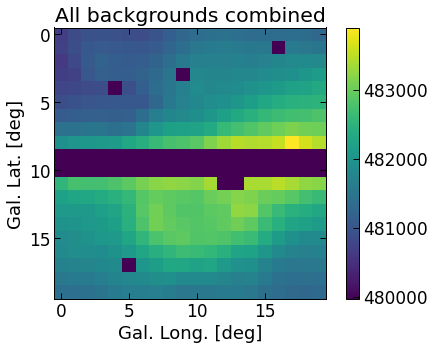

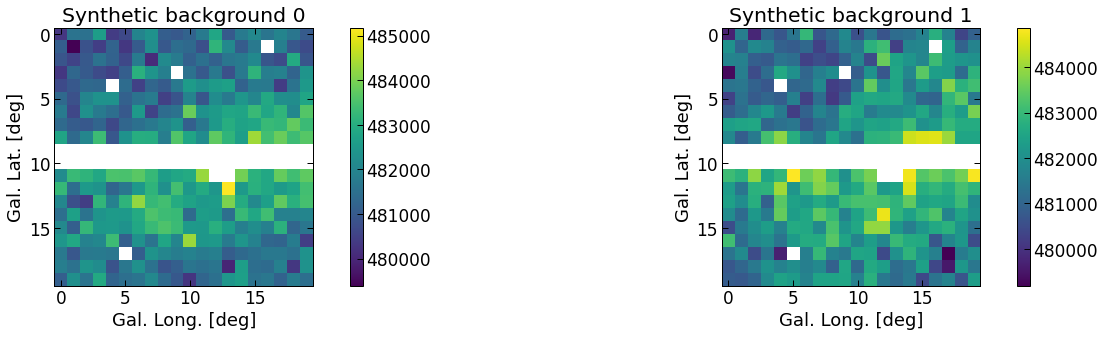

In [ ]:
all_backgrounds = [res_back_template, Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]


for i in all_backgrounds:
  print (i.shape)

signal_strengts = np.logspace(-2.5,1,ss_steps)      
injection_spectra = 0                             ### signal injection type 

signal_conv = signal_templates[injection_spectra]
all_backgrounds = np.array(all_backgrounds)


def random_counts_with_signal(signal_strength, all_backgrounds, signal_conv):
  """  Function that creates a synthetic background map

  inputs:
  --------------
  all_backgrounds: 'n*20*20 array' array with all the different background maps
  signal_conv: '20*20 array' count map of the background signal

  output:
  --------------
  count matrix: '20*20 array' a synthetic data map for CTA
  """

  count_matrix = np.zeros(signal_conv.shape)
  for mapn in all_backgrounds:
    after_norm = np.random.poisson(mapn)
    count_matrix += after_norm

  signal_norm = signal_conv * signal_strength
  count_matrix += np.random.poisson(signal_norm)

  return count_matrix


### Creating array with a range of simulated data 
all_simulated_background = []
for ss in signal_strengts:
  list_MC = []
  for _ in range(MC_times):
    a = random_counts_with_signal(ss, all_backgrounds, signal_conv)
    list_MC.append(np.ma.array(a, mask=mask2))    ### Mask the data
  all_simulated_background.append(list_MC)


## PLotting an example
fig,ax = plt.subplots(figsize = (7,5))
a = ax.imshow(np.sum(all_backgrounds, axis = 0)[0])
ax.set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'All backgrounds combined')
fig.colorbar(a, ax = ax)
plt.show()

fig,ax = plt.subplots(1,2,figsize = (20,5))

for i in range(2):
  a = ax[i].imshow(all_simulated_background[0][i][0])
  ax[i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Synthetic background {i}')
  fig.colorbar(a, ax = ax[i])

fig.tight_layout()

plt.show()



#The bin by bin analysis class

In [ ]:
class analysis:

  def __init__(self, signal_strength, model_backgrounds,signal1,data_map, dm_map = []):
    self.signal_strength = signal_strength
    self.counts_m = data_map
    self.all_backgrounds = model_backgrounds
    self.signal_conv = signal1
    self.signal1 = signal1
    self.energy_bin =  energy_bin
    self.variance = np.std(data_map)**2
    self.dm_map = dm_map


  def L0_model_long(self, params):
    """
    The background only model: H0

    input:
    --------------
    params: 'list' list of normalisation values.

    output:
    --------------
    tot_back: '20*20 array' total map predicted by the map for a given set of normalisations.
    """




    tot_back = np.sum(params[:len(self.all_backgrounds)][:, None, None] * self.all_backgrounds, axis = 0)
    
    if dark_matter_s:
      tot_back += params[-1] * self.signal1
      

    return tot_back
    

  def L1_model_long(self, params):
    """
    The background only model: H0

    input:
    --------------
    params: 'list' list of normalisation values.

    output:
    --------------
    tot_back: '20*20 array' total map predicted by the map for a given set of normalisations.
    """

    

    tot_back = np.sum(params[:len(self.all_backgrounds)][:, None, None] * self.all_backgrounds, axis = 0)

    if dark_matter_s:
      tot_back += params[-2] * self.dm_map 

    tot_back += params[-1] * self.signal1

    
    return tot_back


  
  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters  of the background only model


    input:
    -------------
    params: 'list' list of normalisation values

    output:
    -------------
    li: 'float' total likelihood of the model for a given set of normalisations

    """
    counts = self.counts_m
    counts_model = self.L0_model_long(params)

    li = np.sum((counts - counts_model)**2) / self.variance
    return 0.5*li



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the background + signal model

    input:
    -------------
    params: 'list' list of normalisation values

    output:
    -------------
    li: 'float' total likelihood of the model for a given set of normalisations

    """
    p_sum = 0
    counts = self.counts_m
    counts_model = self.L1_model_long(params)

    li = np.sum((counts - counts_model)**2) / self.variance
    return 0.5*li
  
  def Test_stat(self):
    """
    Function that calculated the maximum likelihood for two models

    output:
    -------------
    T: 'float' test statistic
    c,m_0: gives the strength of the maximum likelihood analysis of the null hypothesis
    d,m_1: gives the strength of the maximum likelihood analysis of the alternative hypothesis with a signal

    """

    init_gues0 = [1 for __ in range(len(self.all_backgrounds))]
    init_gues1 = [1 for __ in range(len(self.all_backgrounds))]
    range0 = (0, 100)
    range1 = (0, 100)
    limit_list1 = [range0 for __ in range(len(self.all_backgrounds))]
    limit_list2 = [range1 for __ in range(len(self.all_backgrounds))]

    limit_list2.append((0, None))
    init_gues1.append(self.signal_strength)
    
    if dark_matter_s:
      limit_list1.append((0, None))
      init_gues0.append(self.signal_strength)

      limit_list2.append((0, None))
      init_gues1.append(self.signal_strength)
   
    
    m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.1, limit= limit_list1, errordef=0.5)
    m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.1, limit= limit_list2, errordef=0.5)
    c = m_0.migrad() 
    d = m_1.migrad()
    a = -m_0.fval 
    b = -m_1.fval
    T = -2*(a-b)
    return T, c,d,m_0,m_1


# Doing the analysis

In [ ]:
def likelihood_analysis(injection_spectra):

  """
  Function that applies the likelihood analysis to the data 

  input:
  --------------
  injection_spectra: 'integer' the injection spectra for which we find the extracted signal.

  output:
  --------------

  all_T : '11*20 array'                          array with all extracted TS signals
  all_f : '11*20*background_maps array'          array with all extracted normalisation vectors
  all_T_std : '11*20 array'                      array with all errors on the extracted TS signals
  all_f_Std : '11*20*background_maps array'      array with all errors on the extracted normalisation vectors


  """


  all_backgrounds = [res_back_template, Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
  signal_conv = signal_templates[injection_spectra]
  all_backgrounds = np.array(all_backgrounds)

  if injection_spectra == 2:
    signal_strengts = np.logspace(-2,3,ss_steps)  
  elif injection_spectra == 1:
    signal_strengts = np.logspace(-2.8,2,ss_steps)  
  else:
    signal_strengts = np.logspace(-2.5,2.5,ss_steps)  



  ### Creating array with a range of simulated data 
  all_simulated_background = []
  for ss in signal_strengts:
    list_MC = []
    for _ in range(MC_times):
      a = random_counts_with_signal(ss, all_backgrounds, signal_conv)
      list_MC.append(np.ma.array(a, mask=mask2))    ### Mask the data
    all_simulated_background.append(list_MC)


  all_T = []
  all_T_std = []
  all_f = []
  all_f_Std = []

  print (f"Calculating for injection spectra {injection_spectra}:")

  for k in tqdm(range(0,11)):     ## We do the analysis for all 11 energy bins

    fit_values = []
    T_values = []
    energy_bin = k
    for signal_bin in range(ss_steps):    ### For every injected signal strength
      ss = signal_strengts[signal_bin]
      local_fit_values = []
      local_T_values = []

      for MC in range(MC_times):                 ### Monte carlo analysis


          if mismodelling:
            model_backgrounds = np.array([res_back_template[energy_bin], Ics_ring_1_template[energy_bin] + Ics_ring_2_template[energy_bin] +  Ics_ring_3_template[energy_bin] + Ics_ring_4_template[energy_bin],
                                          H1_ring_1_template[energy_bin], H1_ring_2_template[energy_bin], H1_ring_3_template[energy_bin],H1_ring_4_template[energy_bin],
                                          H2_ring_1_template[energy_bin], H2_ring_2_template[energy_bin], H2_ring_3_template[energy_bin],H2_ring_4_template[energy_bin],
                                          dust_pos_template[energy_bin] + dust_neg_template[energy_bin], fermi_template[energy_bin]])
          else: 
            model_backgrounds = np.array([res_back_template[energy_bin], Ics_ring_1_template[energy_bin] + Ics_ring_2_template[energy_bin] +  Ics_ring_3_template[energy_bin] + Ics_ring_4_template[energy_bin],
                                          GCE_ring_1_template[energy_bin], GCE_ring_2_template[energy_bin], GCE_ring_3_template[energy_bin], GCE_ring_4_template[energy_bin],
                                          fermi_template[energy_bin]])



          if dark_matter_s:
            dm_map = dark_matter_template[energy_bin]

          signal1 = signal_templates[injection_spectra][energy_bin]
          data_map = all_simulated_background[signal_bin][MC][energy_bin]

          if dark_matter_s:          
            M = analysis(ss, model_backgrounds,signal1,data_map, dm_map = dm_map)
          else:
            M = analysis(ss, model_backgrounds,signal1,data_map)
            
          T, c,d,m_0,m_1 = M.Test_stat()
          a = [m_1.values[x] for x in range(len(m_1.values))]


          local_fit_values.append(a)
          local_T_values.append(T)

      fit_values.append(local_fit_values)
      T_values.append(local_T_values)




    fit_values = np.array(fit_values)
    T_values = np.array(T_values)


    a = np.mean(fit_values, axis = 1)
    b = np.std(fit_values, axis = 1)
    c = np.mean(T_values, axis = 1)
    d = np.std(T_values, axis = 1) 
    
    all_T.append(c)
    all_T_std.append(d)
    all_f.append(a)
    all_f_Std.append(b)

  return all_T, all_f, all_T_std, all_f_Std




if all_injection_plots:

  all_T_tot = []
  all_T_std_tot = []
  all_f_tot = []
  all_f_Std_tot = []

  for injection_spectra in range(5):
    all_T, all_f, all_T_std, all_f_Std = likelihood_analysis(injection_spectra)
    all_T_tot.append(all_T)
    all_T_std_tot.append(all_T_std)
    all_f_tot.append(all_f)
    all_f_Std_tot.append(all_f_Std)


  all_T_tot = np.array(all_T_tot)
  all_f_tot = np.array(all_f_tot)
  all_T_std_tot = np.array(all_T_std_tot)
  all_f_Std_tot = np.array(all_f_Std_tot)


else:

  all_T, all_f, all_T_std, all_f_Std = likelihood_analysis(At_injection_spectra)
  all_T = np.array(all_T)
  all_f = np.array(all_f)
  all_T_std = np.array(all_T_std)
  all_f_Std = np.array(all_f_Std)






Calculating for injection spectra 0:



Calculating for injection spectra 1:



Calculating for injection spectra 2:



Calculating for injection spectra 3:



Calculating for injection spectra 4:


## Putting it in txt files

In [ ]:
#files_paths = '/content/drive/My Drive/Colab Notebooks/Fits_values/'
#file1 = open(files_paths + f'all_T_inj_{injection_spectra}', "w")
#file2 = open(files_paths + f'all_f_inj_{injection_spectra}', "w")

#file3 = open(files_paths + f'all_T_inj_{injection_spectra}_std', "w")
#file4 = open(files_paths + f'all_f_inj_{injection_spectra}_std', "w")

#for i in np.ndindex(all_T.shape):
#  np.savetxt(file1, [all_T[i]])

#for i in np.ndindex(all_f.shape):
#  np.savetxt(file2, [all_f[i]])

#for i in np.ndindex(all_T_std.shape):
#  np.savetxt(file3, [all_T_std[i]])

#for i in np.ndindex(all_f.shape):
#  np.savetxt(file4, [all_f_Std[i]])


#file1.close()
#file2.close()  
#file3.close()
#file4.close()  

In [ ]:
#injection_spectra = 0

#files_paths = '/content/drive/My Drive/Colab Notebooks/Fits_values/'
#all_T = np.loadtxt(files_paths + f'all_T_inj_{injection_spectra}').reshape(11,ss_steps)
#all_f = np.loadtxt(files_paths + f'all_f_inj_{injection_spectra}').reshape(11,ss_steps, 7)
#all_T_std = np.loadtxt(files_paths + f'all_T_inj_{injection_spectra}_std').reshape(11,ss_steps)
#all_f_Std = np.loadtxt(files_paths + f'all_f_inj_{injection_spectra}_std').reshape(11,ss_steps, 7)

# Plotting the results


### The plot settings

In [ ]:
import matplotlib as mpl

def plot_setttings_1():
  sns.reset_orig()
  mpl.rcParams['font.size'] = 17.0
  mpl.rcParams['lines.linewidth'] = 1.5
  mpl.rcParams['lines.linestyle'] = '-'
  mpl.rcParams['axes.linewidth'] = 1.0
  mpl.rcParams['axes.labelsize'] = 15.0
  mpl.rcParams['xtick.major.size'] = 6
  mpl.rcParams['xtick.major.width'] = 1
  mpl.rcParams['xtick.minor.size'] = 3
  mpl.rcParams['xtick.minor.width'] = 1
  mpl.rcParams['ytick.major.size'] = 6
  mpl.rcParams['ytick.major.width'] = 1
  mpl.rcParams['ytick.minor.size'] = 3
  mpl.rcParams['ytick.minor.width'] = 1
  mpl.rcParams['xtick.direction'] = 'in'
  mpl.rcParams['ytick.direction'] = 'in'
  mpl.rcParams['xtick.top'] = True
  mpl.rcParams['ytick.right'] = True
  mpl.rcParams['legend.fontsize'] = 'small'
  mpl.rcParams['figure.figsize'] = (7, 5)
  mpl.rcParams['savefig.bbox'] = 'tight'
  mpl.rcParams['savefig.pad_inches'] = 0.1

def plot_settings_2():
  sns.reset_orig()
  mpl.rcParams['font.size'] = 17.0
  mpl.rcParams['lines.linewidth'] = 1.5
  mpl.rcParams['lines.linestyle'] = '-'
  mpl.rcParams['axes.linewidth'] = 1.0
  mpl.rcParams['axes.labelsize'] = 18.0
  mpl.rcParams['xtick.major.size'] = 6
  mpl.rcParams['xtick.major.width'] = 1
  mpl.rcParams['xtick.minor.size'] = 3
  mpl.rcParams['xtick.minor.width'] = 1
  mpl.rcParams['ytick.major.size'] = 6
  mpl.rcParams['ytick.major.width'] = 1
  mpl.rcParams['ytick.minor.size'] = 3
  mpl.rcParams['ytick.minor.width'] = 1
  mpl.rcParams['xtick.direction'] = 'in'
  mpl.rcParams['ytick.direction'] = 'in'
  mpl.rcParams['xtick.top'] = True
  mpl.rcParams['ytick.right'] = True
  mpl.rcParams['legend.fontsize'] = 'small'
  mpl.rcParams['figure.figsize'] = (7, 5)
  mpl.rcParams['savefig.bbox'] = 'tight'
  mpl.rcParams['savefig.pad_inches'] = 0.1

def plot_settings_3():
  sns.reset_orig()
  mpl.rcParams['font.size'] = 15.0
  mpl.rcParams['lines.linewidth'] = 1.5
  mpl.rcParams['lines.linestyle'] = '-'
  mpl.rcParams['axes.linewidth'] = 1.0
  mpl.rcParams['axes.labelsize'] = 16.0
  mpl.rcParams['xtick.major.size'] = 6
  mpl.rcParams['xtick.major.width'] = 1
  mpl.rcParams['xtick.minor.size'] = 3
  mpl.rcParams['xtick.minor.width'] = 1
  mpl.rcParams['ytick.major.size'] = 6
  mpl.rcParams['ytick.major.width'] = 1
  mpl.rcParams['ytick.minor.size'] = 3
  mpl.rcParams['ytick.minor.width'] = 1
  mpl.rcParams['xtick.direction'] = 'in'
  mpl.rcParams['ytick.direction'] = 'in'
  mpl.rcParams['xtick.top'] = True
  mpl.rcParams['ytick.right'] = True
  mpl.rcParams['legend.fontsize'] = 'small'
  mpl.rcParams['savefig.bbox'] = 'tight'
  mpl.rcParams['savefig.pad_inches'] = 0.1



### TS values

0.5512889788770678
8.520333401390866e+35
0.15353482437682273
4.272064596350383e+35
18.873918221350976
2.1776381363145643e+36
1.2195704601594415
1.6347260444600895e+36
0.5512889788770678
8.660503212602166e+35


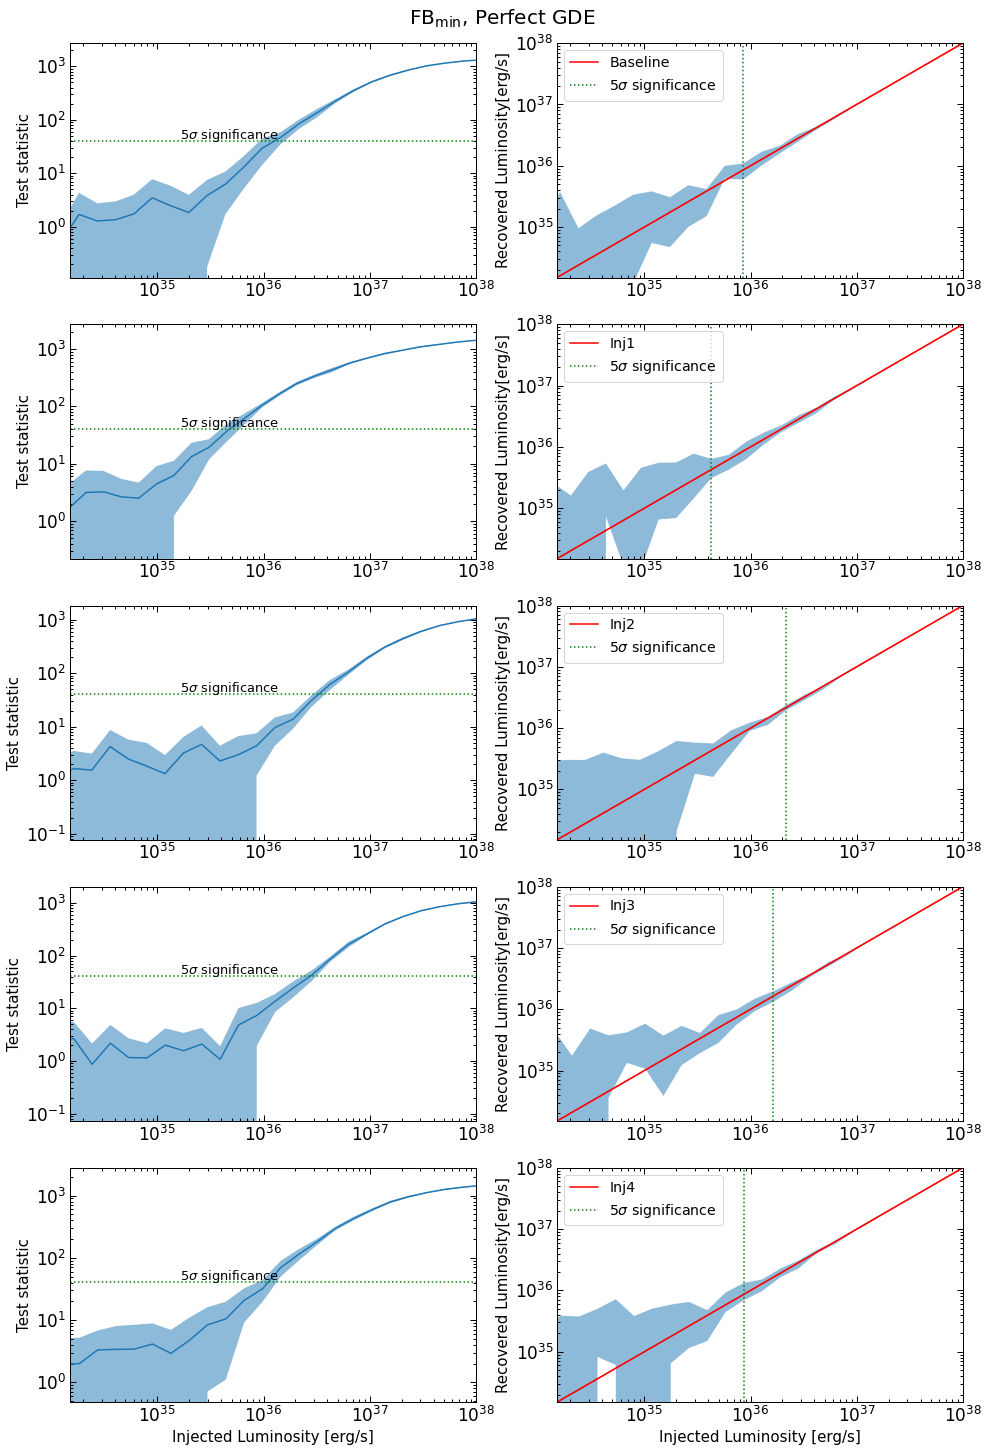

In [ ]:
plot_setttings_1()

def TS_plot(injection_spectra):

  """
  Function that makes the results of the analysis ready to plot

  input:
  --------------
  injection_spectra: 'integer' the injection spectra for which we find the extracted signal.

  output:
  --------------

  total_T :
  error_T : 
  total_injected :
  total_recovered :
  tot_error :
  thresh_lum :
  signal :

  """

  
  if injection_spectra == 2:
    signal_strengts = np.logspace(-2,3,ss_steps)  
  elif injection_spectra == 1:
    signal_strengts = np.logspace(-2.8,2,ss_steps)  
  else:
    signal_strengts = np.logspace(-2.5,2.5,ss_steps)  

  extracted = []
  error = []

  if all_injection_plots:
    all_f_l = all_f_tot[injection_spectra]
    all_f_Std_l = all_f_Std_tot[injection_spectra]
    all_T_l = all_T_tot[injection_spectra]
    all_T_std_l = all_T_std_tot[injection_spectra]
  
  else:
    all_f_l = all_f
    all_f_Std_l = all_f_Std
    all_T_l = all_T
    all_T_std_l = all_T_std



  for i in all_f_l:
    a = [x[-1] for x in i]
    extracted.append(a)

  for i in all_f_Std_l:
    a = [x[-1] for x in i]
    error.append(a)

  extracted = np.array(extracted)
  error = np.array(error)

  ####### Converting to 11 energy bins #######
  a = signals[injection_spectra]
  signal_per_new_bin = []
  for i in range(11):
    j = 2+4*i
    signal_per_new_bin.append(np.sum(a[j]) + np.sum(a[j+1]) + np.sum(a[j+2])+ np.sum(a[j+3]))


  ####### Converting to Luminosity #######
  erg = 1.602
  total_T = np.sum(all_T_l, axis = 0)
  error_T = np.sum(all_T_std_l, axis = 0)
  signal_signal_per_new_bin = []
  range_oi = 10*10 * (np.pi/180)**2

  for i in range(46):
    signal_signal_per_new_bin.append(np.mean(signals[injection_spectra][i])*(energies[i+1] - energies[i]) * 10**6 * range_oi * (energies[i+1] * energies[i])**0.5 * erg * 4 * np.pi * Sun_to_centrum**2 )

  #### Total signal
  signal = np.sum(signal_signal_per_new_bin)
  #### In 11 energy bins
  signal_per_new_bin = [np.sum(signal_signal_per_new_bin[2 + 4*i:4*i+6]) for i in range(11)]


  #### multiplying the signal with the normalisation factors #####
  total_injected = np.sum([signal_strengts * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
  total_recovered = np.sum([extracted[i] * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
  tot_error = np.sum([error[i] * signal_per_new_bin[i] for i in range(11)] ,axis = 0)


  ##### find Threshhold luminosity
  thresh_lum = 0
  for i,T in enumerate(total_T):
    if T> 41:
      thresh_lum = total_injected[i-1]
      print (signal_strengts[i-1])
      break
  print (thresh_lum)

  return total_T, error_T, total_injected, total_recovered, tot_error, thresh_lum,signal,extracted



if all_injection_plots:
  fig,ax = plt.subplots(5,2,figsize= (16,25)) 

  for injection_spectra in range(5):
      
    if injection_spectra == 2:
      signal_strengts = np.logspace(-2,3,ss_steps)  
    elif injection_spectra == 1:
      signal_strengts = np.logspace(-2.8,2,ss_steps)  
    else:
      signal_strengts = np.logspace(-2.5,2.5,ss_steps)   

    total_T, error_T, total_injected, total_recovered, tot_error, thresh_lum,signal,extracted = TS_plot(injection_spectra)

    ax[injection_spectra][0].plot(signal_strengts * signal, total_T)
    ax[injection_spectra][0].fill_between(signal_strengts * signal, total_T-error_T, total_T+error_T, alpha = 0.5)
    ax[injection_spectra][0].set_xscale('log')
    ax[injection_spectra][0].set_yscale('log')
    ax[injection_spectra][0].axhline(41, linestyle = ':', color = 'g')
    #ax[injection_spectra][0].set_xlabel(r'Injected Luminosity [erg/s] )')
    ax[injection_spectra][0].set_ylabel('Test statistic')

    ax[injection_spectra][0].annotate('$5\sigma$ significance ', (float(1.65 * 10**35), 44), size = 13)


    ax[injection_spectra][0].set_xlim(float(1.5 * 10**34),float(10**38))
    
    if injection_spectra ==0:
      ax[injection_spectra][1].plot(total_injected,total_injected, color = 'r', alpha = 1, label = 'Baseline')
    else:
      ax[injection_spectra][1].plot(total_injected,total_injected, color = 'r', alpha = 1, label = f'Inj{injection_spectra}')



    ax[injection_spectra][1].plot(total_injected,total_injected, color = 'r', alpha = 0.5)
    ax[injection_spectra][1].fill_between(total_injected, (total_recovered - tot_error), (total_recovered + tot_error), alpha = 0.5)
    ax[injection_spectra][1].set(yscale ='log', xscale = 'log')
    ax[injection_spectra][1].axvline(thresh_lum, color = 'g', linestyle = ':',label= '$5\sigma$ significance')
    #ax[injection_spectra][1].set_xlabel(r'Injected Luminosity [erg/s]')
    ax[injection_spectra][1].set_ylabel(r'Recovered Luminosity[erg/s]')
    #ax1.set_ylim(33,37)
    ax[injection_spectra][1].legend(loc = 2)
    ax[injection_spectra][1].set_xlim(float(1.5 * 10**34),float(10**38))
    ax[injection_spectra][1].set_ylim(float(1.5 * 10**34),float(10**38))
    

  ax[4][1].set_xlabel(r'Injected Luminosity [erg/s]')
  ax[4][0].set_xlabel(r'Injected Luminosity [erg/s]')


  if Fermi_min:
    if mismodelling:
      title = r'FB$_{\rm min}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm min}$, Perfect GDE'
  else:
    if mismodelling:
      title = r'FB$_{\rm max}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm max}$, Perfect GDE'


  fig.suptitle(title,y=0.90, fontsize=20)

  plt.savefig(f"all_TS_mis={mismodelling}_Fermi_min={Fermi_min}.pdf",bbox_inches='tight')
  plt.show()

else: 

  if injection_spectra == 2:
    signal_strengts = np.logspace(-2,3,ss_steps)  
  elif injection_spectra == 1:
    signal_strengts = np.logspace(-2.8,2,ss_steps)  
  else:
    signal_strengts = np.logspace(-2.5,2.5,ss_steps)  

  fig,ax = plt.subplots(1,2,figsize= (16,5)) 
  total_T, error_T, total_injected, total_recovered, tot_error, thresh_lum, signal,extracted = TS_plot(At_injection_spectra)
  ax[0].plot(signal_strengts * signal, total_T, color = 'b')
  ax[0].fill_between(signal_strengts * signal, total_T-error_T, total_T+error_T, alpha = 0.5)
  ax[0].set_xscale('log')
  ax[0].set_yscale('log')
  ax[0].axhline(41, linestyle = ':', color = 'g')
  #ax[injection_spectra][0].set_xlabel(r'Injected Luminosity [erg/s] )')
  ax[0].set_ylabel('Test statistic')

  ax[0].annotate('$5\sigma$ significance ', (float(1.65 * 10**35), 44), size = 13)


  ax[0].set_xlim(float(1.5 * 10**34),float(10**38))

  if injection_spectra ==0:
    ax[1].plot(total_injected,total_injected, color = 'r', alpha = 1, label = 'Baseline')
  else:
    ax[1].plot(total_injected,total_injected, color = 'r', alpha = 1, label = f'Inj{injection_spectra}')



  ax[1].plot(total_injected,total_injected, color = 'r', alpha = 0.5)
  ax[1].fill_between(total_injected, (total_recovered - tot_error), (total_recovered + tot_error), alpha = 0.5)
  ax[1].set(yscale ='log', xscale = 'log')
  if thresh_lum != 0:
    ax[1].axvline(thresh_lum, color = 'g', linestyle = ':',label= '$5\sigma$ significance')
  else:
    pass
  #ax[injection_spectra][1].set_xlabel(r'Injected Luminosity [erg/s]')
  ax[1].set_ylabel(r'Recovered Luminosity[erg/s]')
  #ax1.set_ylim(33,37)
  ax[1].legend(loc = 2)
  ax[1].set_xlim(float(1.5 * 10**34),float(10**38))
  ax[1].set_ylim(float(1.5 * 10**34),float(10**38))


  ax[1].set_xlabel(r'Injected Luminosity [erg/s]')
  ax[0].set_xlabel(r'Injected Luminosity [erg/s]')


  if Fermi_min:
    if mismodelling:
      title = r'FB$_{\rm min}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm min}$, Perfect GDE'
  else:
    if mismodelling:
      title = r'FB$_{\rm max}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm max}$, Perfect GDE'


  fig.suptitle(title, fontsize=20)

  plt.savefig(f"all_TS_mis={mismodelling}_Fermi_min={Fermi_min}.pdf",bbox_inches='tight')
  plt.show()

  


In [ ]:
print (signal_strengts[13])

0.5512889788770678


In [ ]:
####### Converting to Luminosity #######
erg = 1.602
signal_signal_per_new_bin = []
range_oi = 10*10 * (np.pi/180)**2
injection_spectra = 1

for i in range(46):
  signal_signal_per_new_bin.append(np.mean(signals[injection_spectra][i])*(energies[i+1] - energies[i]) * 10**6 * range_oi * (energies[i+1] * energies[i])**0.5 * erg * 4 * np.pi * Sun_to_centrum**2 )

#### Total signal
signal = np.sum(signal_signal_per_new_bin)
#### In 11 energy bins
signal_per_new_bin = [np.sum(signal_signal_per_new_bin[2 + 4*i:4*i+6]) for i in range(11)]


#### multiplying the signal with the normalisation factors #####
total_injected = np.sum([signal_per_new_bin[i] for i in range(11)] ,axis = 0)

print (total_injected)

2.782472715027435e+36


### Plot for the dark matter case:

In [ ]:
if dark_matter_s:
  
  extracted = []
  error = []
  for i in all_f:
    a = [x[-1] for x in i]
    extracted.append(a)

  dm_extracted = []
  error2 = []
  for i in all_f:
    a = [x[-2] for x in i]
    dm_extracted.append(a)


  for i in all_f_Std:
    a = [x[-1] for x in i]
    error.append(a)

  for i in all_f_Std:
    a = [x[-2] for x in i]
    error2.append(a)

  extracted = np.array(extracted)
  dm_extracted = np.array(dm_extracted)
  error = np.array(error)
  error2 = np.array(error2)

  a = signals[injection_spectra]
  signal_per_new_bin = []
  for i in range(11):
    j = 2+4*i
    signal_per_new_bin.append(np.sum(a[j]) + np.sum(a[j+1]) + np.sum(a[j+2])+ np.sum(a[j+3]))

  erg = 1.602

  total_T = np.sum(all_T, axis = 0)
  error_T = np.sum(all_T_std, axis = 0)

  signal_signal_per_new_bin = []
  dm_per_new_bin = []
  range_oi = 10*10 * (np.pi/180)**2



  for i in range(46):
    signal_signal_per_new_bin.append(np.mean(signals[injection_spectra][i])*(energies[i+1] - energies[i]) * 10**6 * range_oi * (energies[i+1] * energies[i])**0.5 * erg * 4 * np.pi * Sun_to_centrum**2 )


  for i in range(46):
    dm_per_new_bin.append(np.mean(dark_matter[i])*(energies[i+1] - energies[i]) * 10**6 * range_oi * (energies[i+1] * energies[i])**0.5 * erg * 4 * np.pi * Sun_to_centrum**2 )


  signal = np.sum(signal_signal_per_new_bin)
  signal_per_new_bin = [np.sum(signal_signal_per_new_bin[2 + 4*i:4*i+6]) for i in range(11)]
  dm_signal_per_new_bin = [np.sum(signal_signal_per_new_bin[2 + 4*i:4*i+6]) for i in range(11)]

  total_injected = np.sum([signal_strengts * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
  total_recovered = np.sum([extracted[i] * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
  dm_recovered = np.sum([dm_extracted[i] * dm_signal_per_new_bin[i] for i in range(11)] ,axis = 0)
  tot_error = np.sum([error[i] * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
  tot_error2 = np.sum([error2[i] * dm_signal_per_new_bin[i] for i in range(11)] ,axis = 0)




  print (f"The plot for MC = {MC_times} and injection spectra {injection_spectra}")

  plot_settings_2()

  fig,[ax,ax1] = plt.subplots(1,2,figsize= (18,6)) 
  ax.plot(signal_strengts * signal, total_T, color = 'g')
  ax.fill_between(signal_strengts * signal, total_T-error_T, total_T+error_T, color = 'g', alpha = 0.4)
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.axhline(41, linestyle = ':', color = 'g', label = "Detection threshold ($5\sigma$)")
  ax.set_xlabel(r'Injected Luminosity [erg/s] )')
  ax.set_ylabel('Test statistic')
  ax.set_xlim(float(1.5 * 10**35),float(10**38))
  ax.legend()

  ax1.fill_between(total_injected, (total_recovered - tot_error), (total_recovered + tot_error), alpha = 0.5)
  ax1.plot(total_injected,total_injected, label = 'injected signal', color = 'r')
  ax1.plot(total_injected,total_recovered, label = 'recovered MSP signal', color = 'blue', alpha = 0.5)
  
  ax1.fill_between(total_injected, (dm_recovered - tot_error2), (dm_recovered + tot_error2), alpha = 0.4, color = 'g')
  ax1.plot(total_injected,dm_recovered, label = 'Recovered DM signal', color = 'g')
  ax1.set(yscale ='log', xscale = 'log')
  ax1.set_xlabel(r'Injected Luminosity [erg/s]')
  ax1.set_ylabel(r'Recovered Luminosity[erg/s]')
  ax1.set_xlim(float(1.5 * 10**35),float(10**38))
  ax1.set_ylim(float(1.5 * 10**35),float(10**38))
  ax1.legend()

  if Fermi_min:
    if mismodelling:
      title = r'FB$_{\rm min}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm min}$, Perfect GDE'
  else:
    if mismodelling:
      title = r'FB$_{\rm max}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm max}$, Perfect GDE'


  fig.suptitle(title, fontsize=20)


  plt.savefig(f"TS_dm_mis={mismodelling}_Fermi_min={Fermi_min}.pdf",bbox_inches='tight')
  plt.show()


### Recovered per energy bin

## Fluxes

### Signal plot


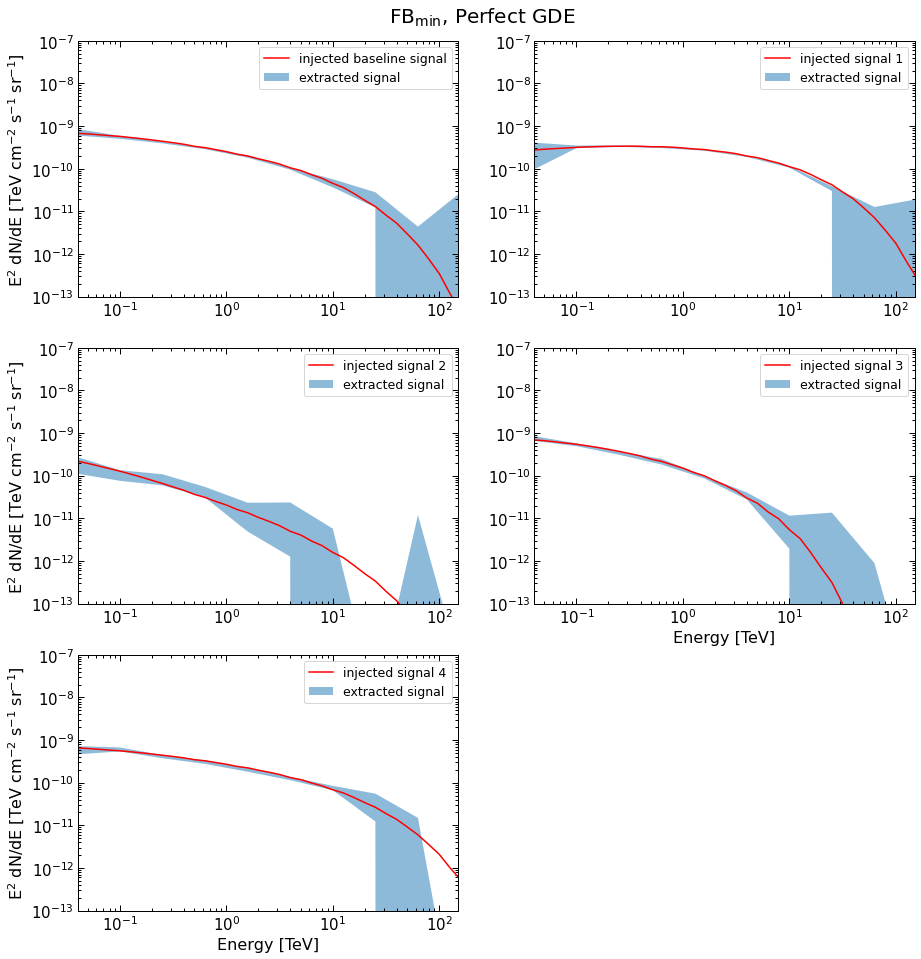

In [ ]:
def signal_plot(injection_spectra):

  """
  Function that finds the extracted signal strength per energy bin. 

  input:
  --------------
  injection_spectra: 'integer' the injection spectra for which we find the extracted signal.

  output:
  --------------

  SI_l : '1*11 array'     array with the injected signal strength per energy bin.
  lower_l : '1*11 array'  the lower limit of the extracted signal.
  upper_l : '1*11 array'  the upper limit of the extracted signal.

  """

  extracted = []
  error = []

  if all_injection_plots:
    all_f_l = all_f_tot[injection_spectra]
    all_f_Std_l = all_f_Std_tot[injection_spectra]
  else:
    all_f_l = all_f 
    all_f_Std_l = all_f_Std
  
  for i in range(len(all_f_l)):
    extracted.append([x[-1] for x in all_f_l[i]])
    error.append([x[-1] for x in all_f_Std_l[i]])

  extracted = np.array(extracted)
  error = np.array(error)

  if injection_spectra == 2:
    signal_strengts = np.logspace(-2,3,ss_steps)  
  elif injection_spectra == 1:
    signal_strengts = np.logspace(-2.8,2,ss_steps)  
  else:
    signal_strengts = np.logspace(-2.5,2.5,ss_steps)  


  total_T = np.sum(all_T, axis = 0)
  
  for i,T in enumerate(total_T):
    if T > 41:
      signal_bin = i
      break
  SI_l = []
  for i in range(47):
    S1 = np.mean((signals[injection_spectra][i])) * energies[i]**2 * 10**6 * signal_strengts[signal_bin]
    SI_l.append(S1)
    #
  SI_l2 = []
  SI_le = []
  for energy_bin in range(11):
    j = 1+energy_bin*4
    S1 = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2
          + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4 * 10**6 * extracted[energy_bin][signal_bin]
    SI_l2.append(S1)

    S1_e = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2
        + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4 * 10**6 * error[energy_bin][signal_bin]
    SI_le.append(S1_e)

  upper_l = []
  lower_l = []
  for i in range(len(new_energies)):
    upper_l.append(SI_l2[i] + SI_le[i])
    lower_l.append(SI_l2[i] - SI_le[i])

  return SI_l, lower_l, upper_l

plot_settings_2()



if all_injection_plots:
  plot_settings_3()
  fig, ax = plt.subplots(3,2,figsize = (15,16))
  for injection_spectra in range(5):

    SI_l, lower_l, upper_l = signal_plot(injection_spectra)
    if injection_spectra == 0:
      ax[injection_spectra//2][injection_spectra % 2].plot(energies,SI_l, label = f'injected baseline signal', color = 'r')


    else:
      ax[injection_spectra//2][injection_spectra % 2].plot(energies,SI_l, label = f'injected signal {injection_spectra}',color = 'r')
    ax[injection_spectra//2][injection_spectra % 2].fill_between(new_energies, lower_l, upper_l, alpha = 0.5, label = f'extracted signal')

    ax[injection_spectra//2][injection_spectra % 2].set_ylim(10**-13,10**-7)
    ax[injection_spectra//2][injection_spectra % 2].set_xlim(0.04,150)
    ax[injection_spectra//2][injection_spectra % 2].set_yscale('log')
    ax[injection_spectra//2][injection_spectra % 2].set_xscale('log')
    ax[2][0].set_xlabel(r'Energy [TeV]')
    ax[1][1].set_xlabel(r'Energy [TeV]')
    if injection_spectra % 2 == 0:
      ax[injection_spectra//2][injection_spectra % 2].set_ylabel(r'E$^{2}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$ sr$^{-1}]$')
    ax[injection_spectra//2][injection_spectra % 2].legend()
  
  if Fermi_min:
    if mismodelling:
      title = r'FB$_{\rm min}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm min}$, Perfect GDE'
  else:
    if mismodelling:
      title = r'FB$_{\rm max}$, mismodeling of the GDE'
    else:
      title = r'FB$_{\rm max}$, Perfect GDE'

  
  fig.suptitle(title,y=0.91, fontsize=20)
  fig.delaxes(ax[2][1])

else:
  plot_settings_2()
  fig, ax = plt.subplots(1,1,figsize = (10,7))
  SI_l, lower_l, upper_l = signal_plot(At_injection_spectra)
  ax.plot(energies,SI_l, label = f'injected signal {injection_spectra}')
  ax.fill_between(new_energies, lower_l, upper_l, alpha = 0.5, label = f'extracted signal {injection_spectra}')

  ax.set_ylim(10**-13,10**-7)
  ax.set_xlim(0.04,150)
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_ylabel(r'E$^{2}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$ sr$^{-1}]$')
  ax.set_xlabel(r'Energy [TeV]')
plt.legend()

if all_injection_plots:
  plt.savefig(f"all_signal_spectra_mis={mismodelling}_Fermi_min-{Fermi_min}.pdf", bbox_inches = 'tight')
else:
  plt.savefig(f"signal_{At_injection_spectra}_spectra.pdf", bbox_inches = 'tight')

plt.show()





In [ ]:
3%2


1